In [23]:
import torch.nn as nn
import torch
import pandas as pd
import pathlib
import numpy as np
import time
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyper parameters
epoch = 10  # epoch
barch_size = 64  # batch size for training
LR = 5  # learning rate

batch_size = 64

In [45]:
'''
1. Access to the raw dataset iterators
'''
from torch.utils.data import DataLoader
from torchtext.datasets import AG_NEWS

train_dataset, test_dataset  = AG_NEWS()

target_classes = ["World", "Sports", "Business", "Sci/Tec"]

In [46]:
'''
2. Prepare data
'''
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocab(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab([train_dataset, test_dataset]), specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

In [47]:
len(vocab.get_itos())

98635

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from torchtext.data.functional import to_map_style_dataset

vectorizer = CountVectorizer(vocabulary=vocab.get_itos(), tokenizer=tokenizer)

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = vectorizer.transform(X).todense()
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y)

train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=256, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=256, collate_fn=vectorize_batch)

In [61]:
for t in train_dataset:
    print(t)
    break
print()

for text, label in train_loader:
    print(label.shape, text.shape)
    break

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

torch.Size([256]) torch.Size([256, 98635])


In [64]:
'''
3. Define the model
'''

from torch.nn import functional as F

class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(len(vocab), 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 4),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)


In [63]:
# test output dimension
text_classifier = TextClassifier()
for X, Y in train_loader:
    Y_preds = text_classifier(X)
    print(Y_preds.shape)
    break

torch.Size([256, 4])


In [38]:
'''
4. Train the model
'''

from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)


In [39]:
from torch.optim import Adam

epochs = 8
learning_rate = 1e-4

loss_fn = nn.CrossEntropyLoss()
text_classifier = TextClassifier()
optimizer = Adam(text_classifier.parameters(), lr=learning_rate)

TrainModel(text_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Train Loss : 0.790
Valid Loss : 0.363
Valid Acc  : 0.894


100%|██████████| 469/469 [00:54<00:00,  8.67it/s]


Train Loss : 0.287
Valid Loss : 0.282
Valid Acc  : 0.912


100%|██████████| 469/469 [00:53<00:00,  8.81it/s]


Train Loss : 0.215
Valid Loss : 0.258
Valid Acc  : 0.917


100%|██████████| 469/469 [00:53<00:00,  8.78it/s]


Train Loss : 0.173
Valid Loss : 0.248
Valid Acc  : 0.918


100%|██████████| 469/469 [00:52<00:00,  8.86it/s]


Train Loss : 0.142
Valid Loss : 0.245
Valid Acc  : 0.917


100%|██████████| 469/469 [00:55<00:00,  8.52it/s]


Train Loss : 0.117
Valid Loss : 0.247
Valid Acc  : 0.918


100%|██████████| 469/469 [00:54<00:00,  8.54it/s]


Train Loss : 0.097
Valid Loss : 0.253
Valid Acc  : 0.917


100%|██████████| 469/469 [00:54<00:00,  8.57it/s]


Train Loss : 0.080
Valid Loss : 0.263
Valid Acc  : 0.916


In [40]:
"""
5. save model
"""
torch.save(text_classifier.state_dict(),"./text_classifier.pth")

In [41]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(text_classifier, test_loader)

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9157894736842105

Classification Report : 
              precision    recall  f1-score   support

       World       0.92      0.92      0.92      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.88      0.89      0.88      1900
     Sci/Tec       0.91      0.87      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600


Confusion Matrix : 
[[1747   46   65   42]
 [  25 1856   12    7]
 [  71   12 1696  121]
 [  64   15  160 1661]]


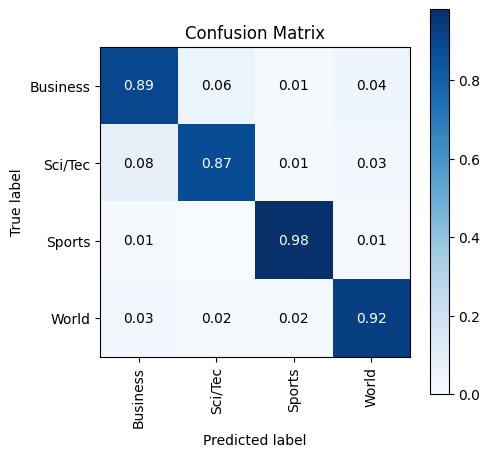

In [43]:


import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

## Using Embedding calculated by DG method

In [67]:
for sample in train_dataset:
    print(sample)
    break

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


In [ ]:
class DGClassifier(nn.Module):

    def __init__(self, sentence_dim = 128):
        super(DGClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(sentence_dim, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 4),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

In [71]:
coords = np.load("Realization_120_30.npy")

[-1.29978191e+00 -4.77783892e-01 -5.19557299e-17 -3.33507191e-16
 -4.59716918e-17 -4.13991645e-17 -4.13991709e-17 -7.99547878e-17
 -1.21356447e-16 -4.60764719e-17 -4.25272849e-17 -4.66888432e-16
 -4.29572323e-17 -2.72154057e-17 -4.86633230e-17 -7.81189974e-15
 -4.13994514e-17 -3.19459394e-17 -4.13985021e-17 -7.22323132e-17
 -4.13995854e-17  8.17440556e-15 -4.13989931e-17 -8.52468747e-16
 -3.33103753e-17  1.10914855e-17 -6.24862841e-17 -4.13987486e-17
 -1.01170104e-16 -5.27057751e-17]
